In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [2]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [3]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields) #0.97483 
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])

In [4]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [5]:
ind_massive = (ts['mvir'] > 10**7)
len(ts['mvir'][ind_massive])

1072

In [6]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS()) 

ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric()) #galactocentric coordinates

In [7]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [8]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [9]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [10]:
#This is the radius from the center at which the maximum velocity occurs
trot['rs'] = (trot['RVmax'])/2.163

In [11]:
subhalo_dist=np.sqrt(trot['x']**2+trot['y']**2+trot['z']**2)

In [12]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))


In [13]:
#Getting the Orbits of Subhalos
dt = 1*u.Myr
subh_orbits = []
Nstep_long=3000
for subh in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh]*u.kpc, y=ts['y'][ind_massive][subh]*u.kpc, 
                                  z=ts['z'][ind_massive][subh]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

In [14]:
#Rotating Subhalo Orbits 
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]
        rot_orbits[j][i][1] = rot_vec[1]
        rot_orbits[j][i][2] = rot_vec[2]

In [22]:
#Rotating Subhalo Velocity Orbits 
N = len(subh_orbits[0].vel.d_x)

rot_orbits_vel=np.zeros((len(ts['vx'][ind_massive]), len(subh_orbits[1].vel.d_x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec_vel = np.array([subh.vel.d_x.to(u.km/u.s)[i].value, 
                                 subh.vel.d_y.to(u.km/u.s)[i].value, 
                                 subh.vel.d_z.to(u.km/u.s)[i].value])
        rot_vec_vel = np.matmul(R, temp_vec_vel)

        rot_orbits_vel[j][i][0] = rot_vec_vel[0]
        rot_orbits_vel[j][i][1] = rot_vec_vel[1]
        rot_orbits_vel[j][i][2] = rot_vec_vel[2]

In [27]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


In [28]:
r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)


In [ ]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

#Information for Gaia-1
c_gaia1 = coord.SkyCoord(ra=190.96*u.deg, dec=-9.16*u.deg, distance=5.57*u.kpc, pm_ra_cosdec=-14.39*u.mas/u.yr,
                  pm_dec=-19.72*u.mas/u.yr, radial_velocity=214.91*u.km/u.s, frame='icrs')

w0_gaia1 = gd.PhaseSpacePosition(c_gaia1.transform_to(gc_frame).cartesian)

In [ ]:
dt = 1*u.Myr
Nstep_foward = 2
orbit_foward_gaia1 = ham.integrate_orbit(w0_gaia1, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs_gaia1 = orbit_foward_gaia1.to_coord_frame(coord.ICRS())

In [ ]:
w0_start_gaia1 = gd.PhaseSpacePosition(orbit_foward_gaia1.pos[-1], orbit_foward_gaia1.vel[-1])
Nstep = 7
orbit_gaia1 = ham.integrate_orbit(w0_start_gaia1, dt=-dt, n_steps=Nstep)
orbit_sky_gaia1 = orbit_gaia1.to_coord_frame(coord.ICRS())

In [ ]:
Nstep_long = 3000
orbit_long_gaia1 = ham.integrate_orbit(w0_start_gaia1, dt=-dt, n_steps=Nstep_long)

In [ ]:
closest_dist_Gaia1 = pd.DataFrame()
data_new = {'Stream':['Gaia-1']}
data_temp = pd.DataFrame(data=data_new)
for subh in range(len(trot['x'])): #subh stands for individual subhalo
    dist_x = orbit_long_gaia1.pos.x - rot_orbits[subh,:,0]*u.kpc 
    dist_y = orbit_long_gaia1.pos.y - rot_orbits[subh,:,1]*u.kpc
    dist_z = orbit_long_gaia1.pos.z - rot_orbits[subh,:,2]*u.kpc
    rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
    closest_dist = np.min(rel_dist)
    data_temp['Subhalo_'+ str(subh)+ ' (kpc)'] = [closest_dist.value]
closest_dist_Gaia1 = closest_dist_Gaia1.append(data_temp, ignore_index=True)


In [ ]:
closest_dist_Gaia1

In [ ]:
closest_dist_Gaia1;
closest_dist_Gaia1.to_csv('Gaia1_Rel_Dist_to_Subhalos.csv', index='False')

In [29]:
# initialize list of lists
data = [['Gjoll', 82.1, -13.95, 3.26, 23.58, -23.7, 78.73], 
        ['Leiptr', 89.11, -28.37, 7.39, 10.59, -9.9, 194.22],
        ['Hrid', 280.51, 33.3, 2.75, -5.88, 20.08, -238.77],
        ['Pal5', 229.65, 0.26, 20.16, -2.75, -2.68, -57.03],
        ['Gaia_1', 190.96, -9.16, 5.57, -14.39, -19.72, 214.91], #Gaia_1
        ['Ylgr', 173.82, -22.31, 9.72, -0.44, -7.65, 317.86], 
        ['Fjorm', 251.89, 65.38, 6.42, 3.92, 3.1, -25.37],
        ['Kshir', 205.88, 67.25, 9.57, -7.67, -3.92, -249.88],
        ['Gunnthra', 284.22, -73.49, 2.83, -15.83, -24.04, 132.26],
        ['Slidr', 160.05, 10.22, 2.99, -24.6, -6.65, 87.98],
        ['M92', 259.89, 43.08, 8.94, -5.15, -0.63, -140.66],
        ['NGC_3201', 152.46, -46.32, 4.99, 8.87, -2.22, 489.63],
        ['Atlas', 25.04, -29.81, 19.93, 0.04, -0.89, -85.65],
        ['C_7', 287.15, -50.17, 6.77, -13.79, -12.38, 55.05],
        ['Palca', 36.57, -36.15, 12.31, 0.9, -0.23, 106.32],
        ['Sylgr', 179.68, -2.44, 3.77, -13.98, -12.9, -184.8],
        ['Gaia_9', 233.27, 60.42, 4.68, -12.49, 6.37, -359.86],
        ['Gaia_10', 161.47, 15.17, 13.32, -4.14, -3.15, 289.62],
        ['Gaia_12', 41.05, 16.45, 15.71, 5.84, -5.66, -303.83],
        ['Indus', 340.12, -60.58, 14.96, 3.59, -4.89, -49.15],
        ['Jhelum', 351.95, -51.74, 11.39, 7.23, -4.37, -1.29],
        ['Phoenix', 23.96, -50.01, 16.8, 2.72, -0.07, 45.92],
        ['NGC5466', 214.41, 26.84, 14.09, -5.64, -0.72, 95.04],
        ['M5', 206.96, 13.5, 7.44, 3.5, -8.76, -42.97],
        ['C_20', 359.81, 8.63, 18.11, -0.58, 1.44, -116.87],
        ['C_19', 355.28, 28.82, 18.04, 1.25, -2.74, -193.48],
        ['Elqui', 19.77, -42.36, 51.41, 0.33, -0.49, 15.86],
        ['AliqaUma', 34.08, -33.97, 21.98, 0.24, -0.79, -42.33],
        ['Phlegethon', 319.89, -32.07, 3.29, -3.97, -37.66, 15.9],
        ['GD_1', 160.02, 45.9, 8.06, -6.75, -10.88, -101.83]
       ]
  
# Create the pandas DataFrame
streams = pd.DataFrame(data, columns=['Stream', 'ra', 'dec', 'distance', 'pm_ra_cosdec', 'pm_dec', 'radial_velocity'])
  

# print dataframe.
streams

,Stream,ra,dec,distance,pm_ra_cosdec,pm_dec,radial_velocity
0,Gjoll,82.10,-13.95,3.26,23.58,-23.70,78.73
1,Leiptr,89.11,-28.37,7.39,10.59,-9.90,194.22
2,Hrid,280.51,33.30,2.75,-5.88,20.08,-238.77
3,Pal5,229.65,0.26,20.16,-2.75,-2.68,-57.03
4,Gaia_1,190.96,-9.16,5.57,-14.39,-19.72,214.91
5,Ylgr,173.82,-22.31,9.72,-0.44,-7.65,317.86
6,Fjorm,251.89,65.38,6.42,3.92,3.10,-25.37
7,Kshir,205.88,67.25,9.57,-7.67,-3.92,-249.88
8,Gunnthra,284.22,-73.49,2.83,-15.83,-24.04,132.26
9,Slidr,160.05,10.22,2.99,-24.60,-6.65,87.98


In [30]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDist(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    for i in range(len(streams)): #goes through every stream
        c = coord.SkyCoord(ra=streams.iloc[i]['ra']*u.deg, dec=streams.iloc[i]['dec']*u.deg, 
                           distance=streams.iloc[i]['distance']*u.kpc, pm_ra_cosdec=streams.iloc[i]['pm_ra_cosdec']*u.mas/u.yr,
                           pm_dec=streams.iloc[i]['pm_dec']*u.mas/u.yr, radial_velocity=streams.iloc[i]['radial_velocity']*u.km/u.s, frame='icrs')

        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


        dt = 1*u.Myr
        Nstep_foward = 2
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

        w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
        Nstep = 7
        orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
        orbit_sky = orbit.to_coord_frame(coord.ICRS())
        
        #Going back for 3 Gyrs (3000 steps of -1Myr)
        Nstep_long = 3000
        orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

        
        
        data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
        data_temp = pd.DataFrame(data=data_new)
        for subh in range(len(trot['x'])): #subh stands for individual subhalo
            dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
            dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
            dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
            rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
            closest_dist2 = np.min(rel_dist)
            
            #For time
            time_occurance = -dt*np.argmin(rel_dist)
            
            #For velocity 
            ind_time = np.argmin(rel_dist)
            vel_x = orbit_long.vel.d_x.to(u.km/u.s) - rot_orbits_vel[subh,:,0]*(u.km/u.s) 
            vel_y = orbit_long.vel.d_y.to(u.km/u.s) - rot_orbits_vel[subh,:,1]*(u.km/u.s)
            vel_z = orbit_long.vel.d_z.to(u.km/u.s) - rot_orbits_vel[subh,:,2]*(u.km/u.s)
            rel_vel = np.sqrt((vel_x**2) + (vel_y**2) + (vel_z**2))
            
            data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
            data_temp['Subhalo_'+ str(subh)+ ' Time (Myr)'] = [time_occurance.value]
            data_temp['Subhalo_'+ str(subh)+ ' Relative Velocity (km/s)'] = [rel_vel[ind_time].value]
            
        closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1

    #closest_dist.to_csv('Closest_Rel_Dist_to_Subhalos.csv', index='False')







In [31]:
#Took this out of the function to access Velocity (not used for later code only for TEST)
i=5
c = coord.SkyCoord(ra=streams.iloc[i]['ra']*u.deg, dec=streams.iloc[i]['dec']*u.deg, 
                           distance=streams.iloc[i]['distance']*u.kpc, pm_ra_cosdec=streams.iloc[i]['pm_ra_cosdec']*u.mas/u.yr,
                           pm_dec=streams.iloc[i]['pm_dec']*u.mas/u.yr, radial_velocity=streams.iloc[i]['radial_velocity']*u.km/u.s, frame='icrs')

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


dt = 1*u.Myr
Nstep_foward = 2
orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
Nstep = 7
orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
orbit_sky = orbit.to_coord_frame(coord.ICRS())

#Going back for 3 Gyrs (3000 steps of -1Myr)
Nstep_long = 3000
orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

        
orbit_long.vel.d_x.to(u.km/u.s)

<Quantity [ 208.2079569 ,  206.53898065,  204.82065367, ..., -129.55244464,
           -129.02572078, -128.47581296] km / s>

In [33]:
pb = ClosestDist(streams)
pb

,Stream,Subhalo_0 Distance (kpc),Subhalo_0 Time (Myr),Subhalo_0 Relative Velocity (km/s),Subhalo_1 Distance (kpc),Subhalo_1 Time (Myr),Subhalo_1 Relative Velocity (km/s),Subhalo_2 Distance (kpc),Subhalo_2 Time (Myr),Subhalo_2 Relative Velocity (km/s),...,Subhalo_1068 Relative Velocity (km/s),Subhalo_1069 Distance (kpc),Subhalo_1069 Time (Myr),Subhalo_1069 Relative Velocity (km/s),Subhalo_1070 Distance (kpc),Subhalo_1070 Time (Myr),Subhalo_1070 Relative Velocity (km/s),Subhalo_1071 Distance (kpc),Subhalo_1071 Time (Myr),Subhalo_1071 Relative Velocity (km/s)
0,Gjoll,23.418654,-287.0,535.449884,88.090466,-2608.0,296.911384,284.533372,-0.0,316.213113,...,418.599307,42.350337,-1395.0,614.321092,55.968812,-639.0,345.898103,31.495516,-858.0,395.382200
1,Leiptr,8.075946,-329.0,443.922337,97.549989,-1227.0,310.032901,288.680598,-0.0,339.015785,...,707.853069,31.424616,-1424.0,434.134925,67.464384,-631.0,622.572517,49.670826,-2420.0,443.734772
2,Hrid,54.796486,-325.0,435.146645,97.453298,-217.0,263.973529,279.122589,-0.0,485.880646,...,547.899317,9.391542,-1417.0,425.026858,46.896940,-650.0,470.980264,32.012198,-791.0,365.728604
3,Pal5,33.962001,-223.0,561.342650,107.766900,-2682.0,314.207870,271.139203,-0.0,145.229740,...,620.570887,16.762270,-1394.0,396.453035,54.415621,-646.0,653.043132,39.862177,-846.0,471.109149
4,Gaia_1,30.611827,-405.0,441.321231,81.579544,-2328.0,378.786945,272.684936,-99.0,144.058028,...,478.043268,21.697515,-1420.0,900.490686,58.330344,-713.0,870.640541,35.905899,-709.0,722.179931
5,Ylgr,31.574246,-281.0,636.041846,102.736961,-2267.0,351.212962,284.445025,-0.0,213.700336,...,642.787372,0.520072,-1398.0,408.938805,53.079061,-743.0,303.426025,25.062857,-804.0,465.630815
6,Fjorm,58.666359,-189.0,461.360785,94.740331,-287.0,208.266036,275.282067,-0.0,522.229130,...,417.098239,8.104039,-1478.0,506.619400,58.715624,-658.0,515.536697,40.313771,-2437.0,631.711510
7,Kshir,41.470491,-244.0,632.240152,102.753624,-2787.0,438.489046,273.903845,-0.0,133.577741,...,602.887049,26.736988,-1420.0,686.746532,63.149903,-712.0,600.598879,27.578549,-723.0,503.924993
8,Gunnthra,38.755451,-293.0,408.741276,110.538472,-2849.0,299.454475,283.581716,-0.0,233.595160,...,584.646301,16.510132,-1410.0,723.727529,59.011514,-667.0,485.898453,41.409366,-727.0,451.056581
9,Slidr,41.036184,-301.0,511.147252,103.437170,-248.0,348.393516,281.807700,-0.0,368.855681,...,553.687188,22.117424,-1367.0,606.723956,49.904962,-784.0,411.331282,25.106130,-752.0,476.455107


In [37]:
pb.to_csv('Closest_Distance_Subhalo_to_All_Streams.csv', index='False')

<ipython-input-52-a143e0108d1e>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


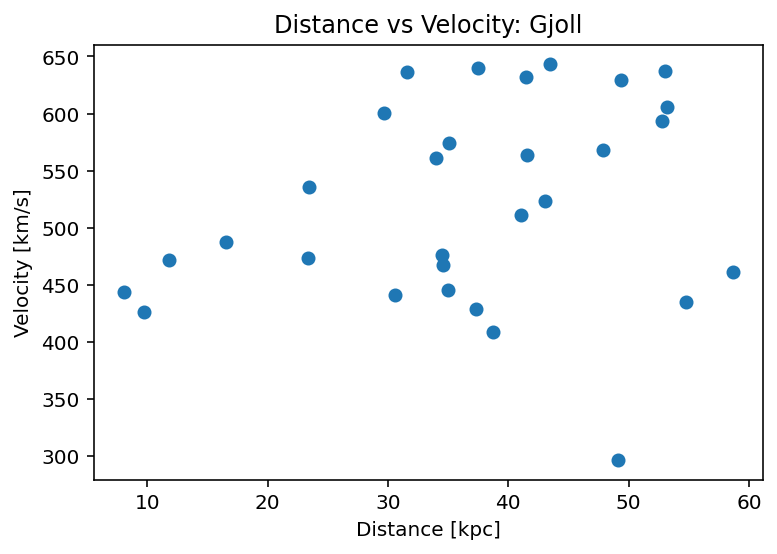

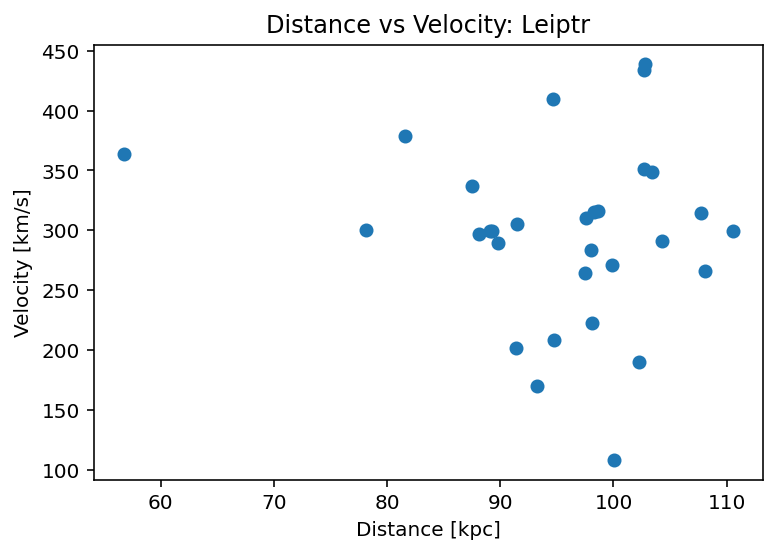

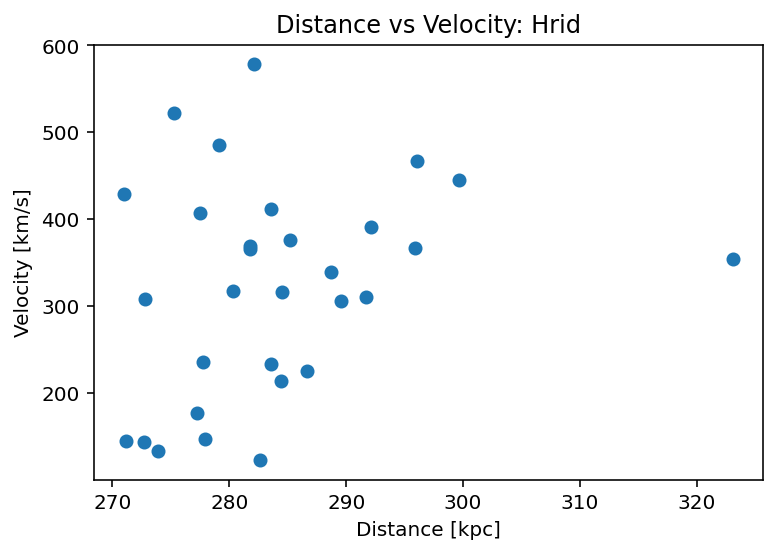

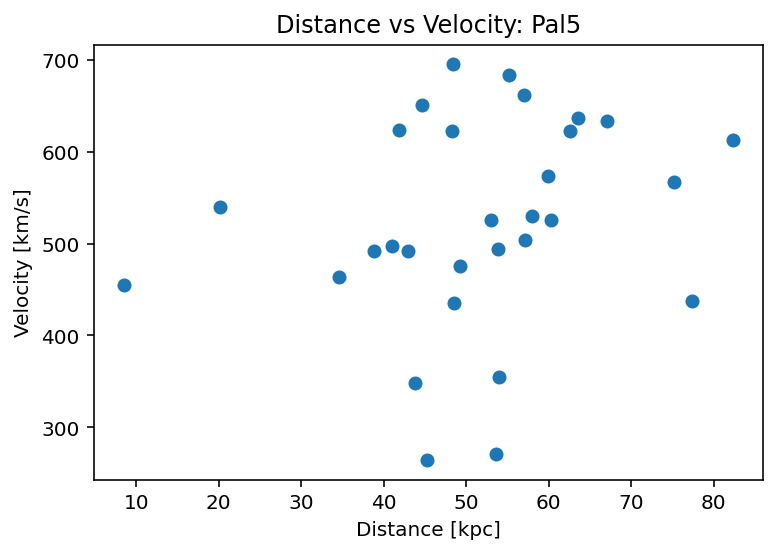

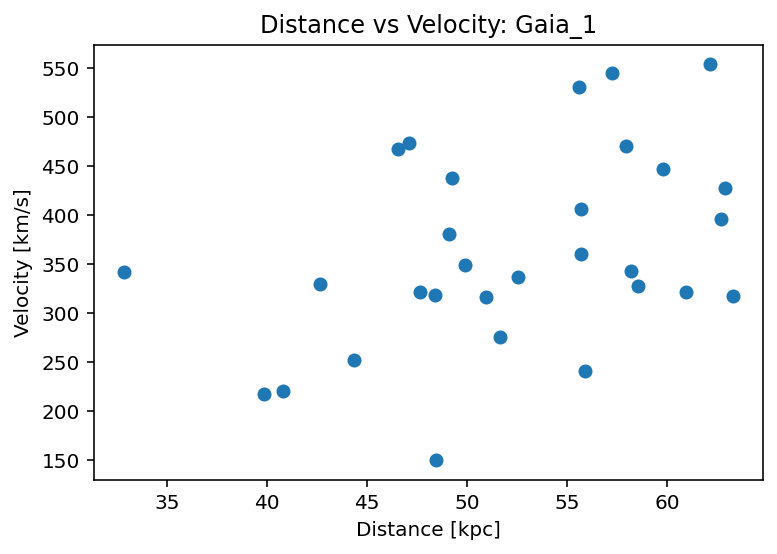

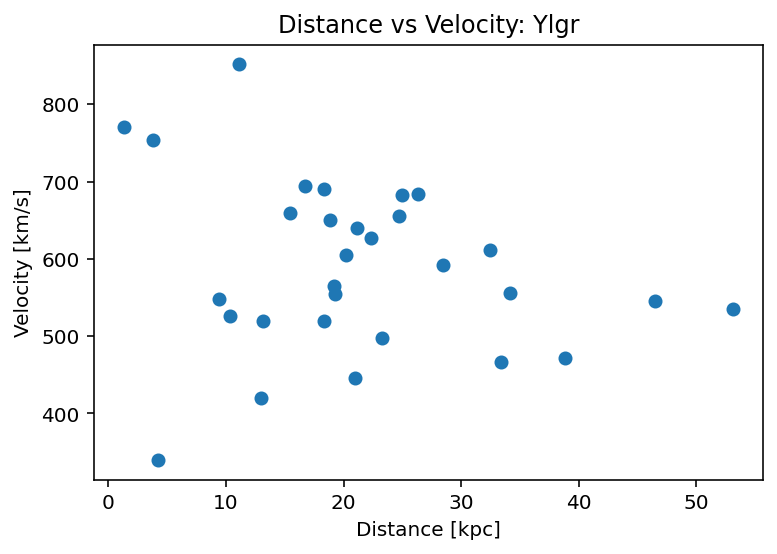

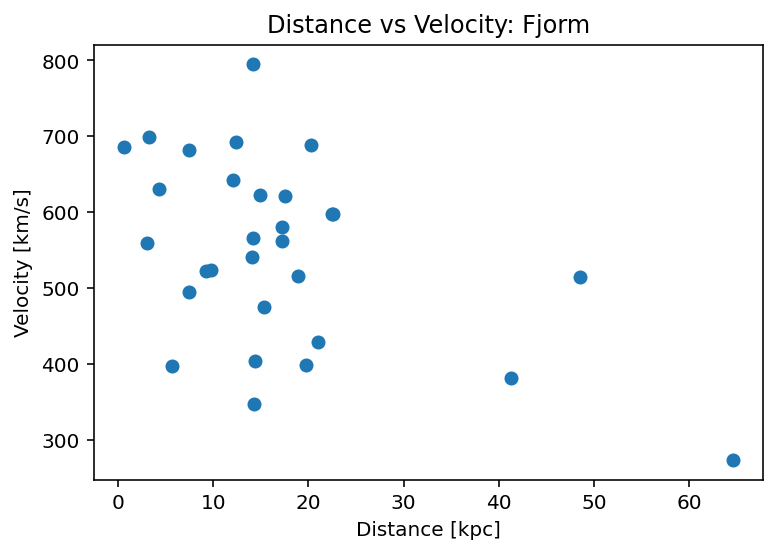

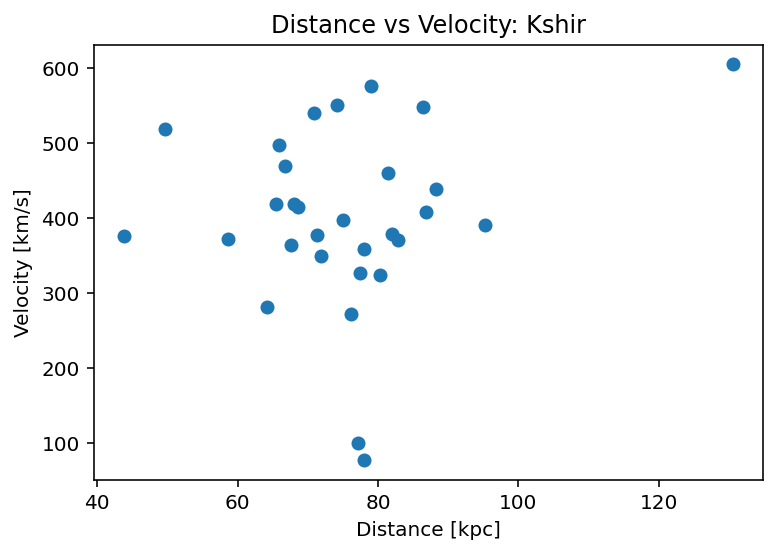

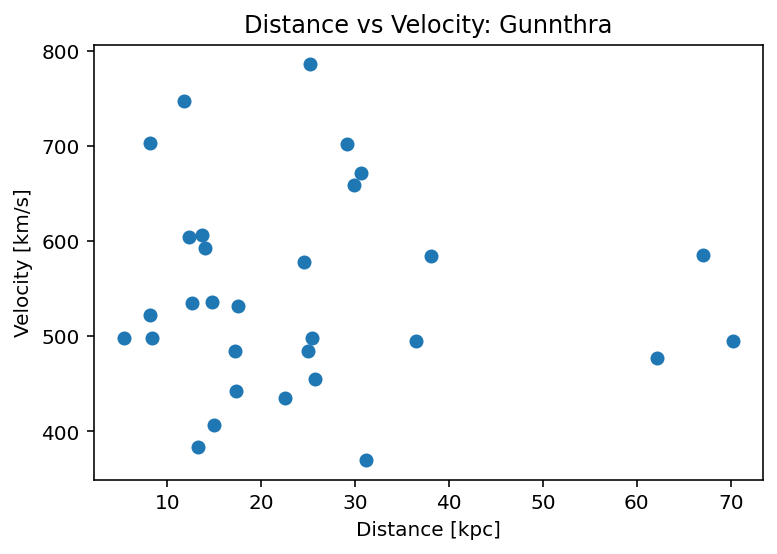

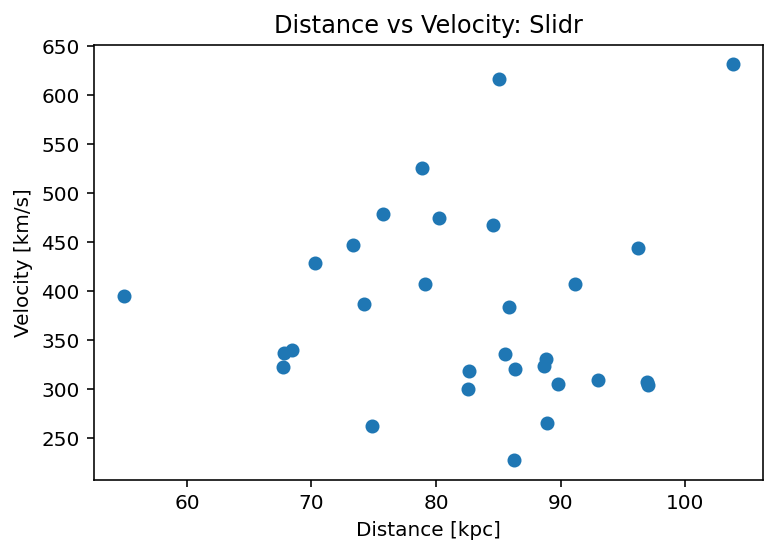

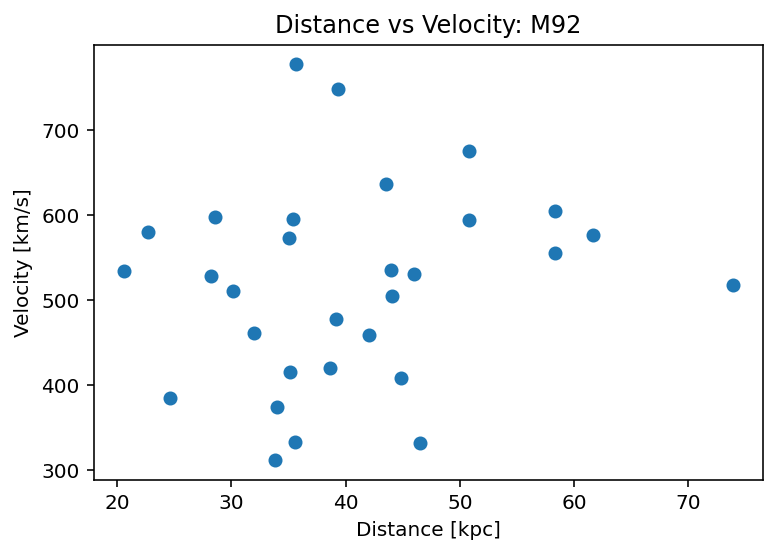

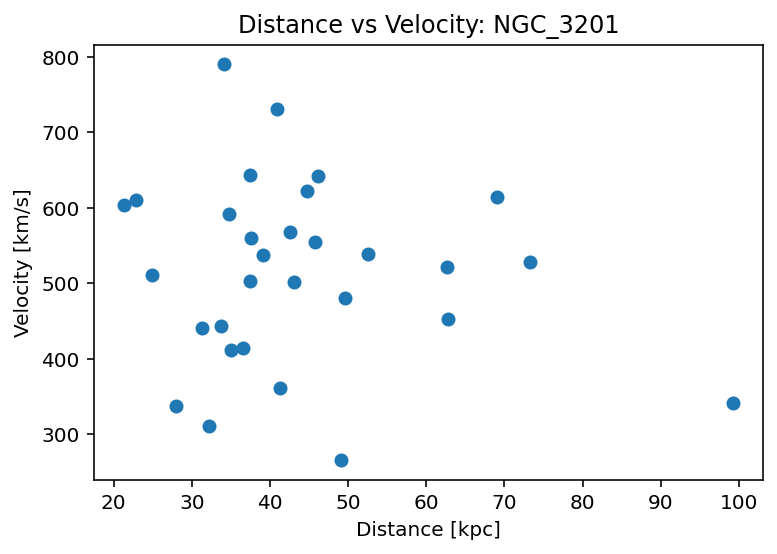

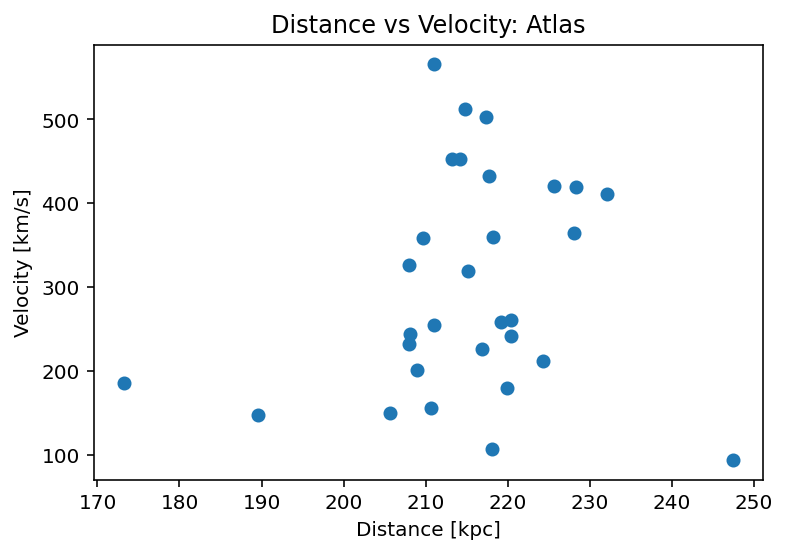

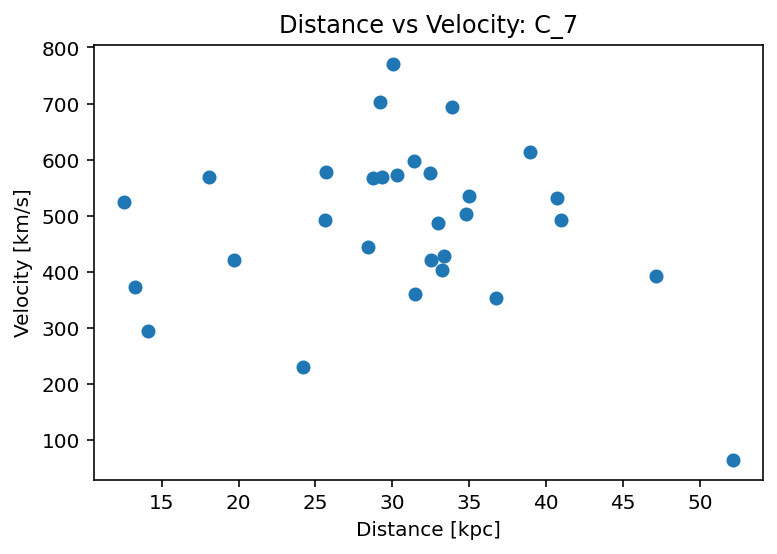

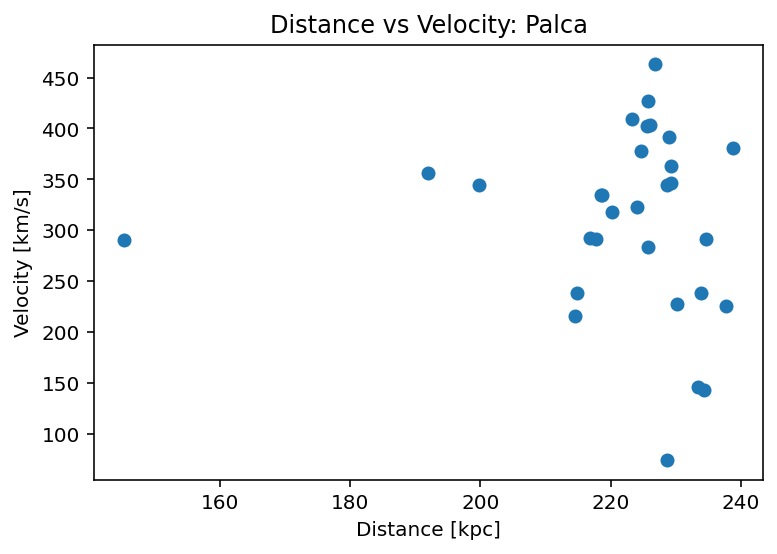

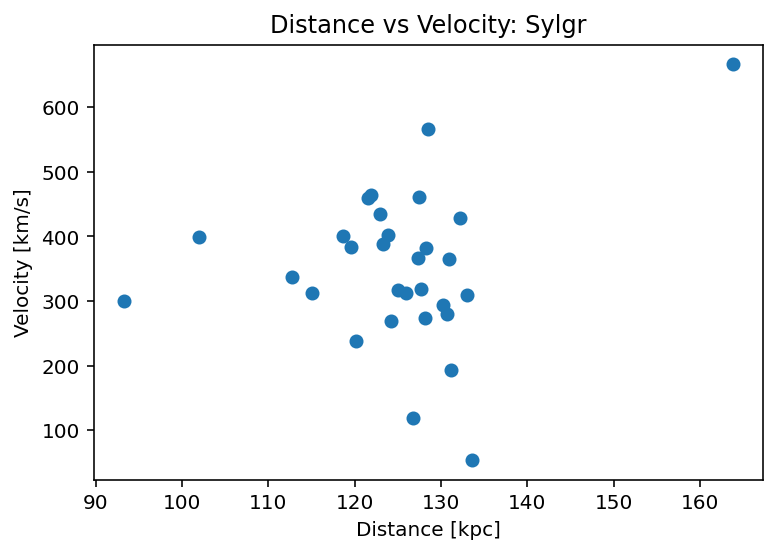

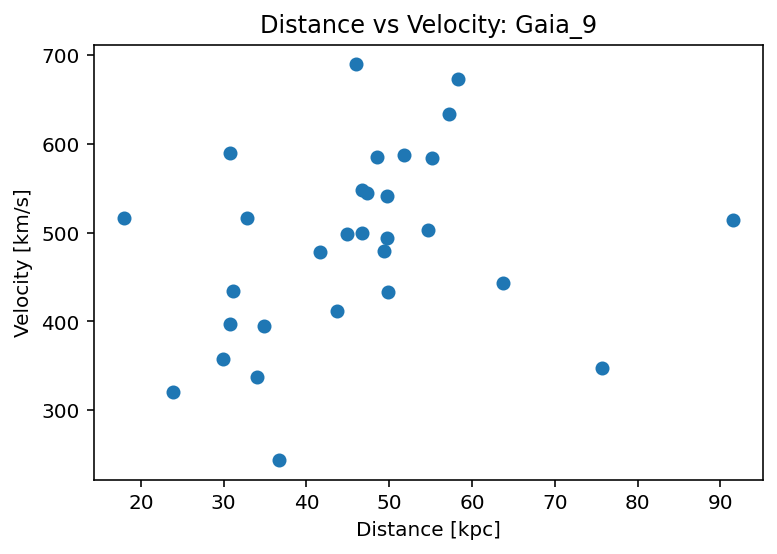

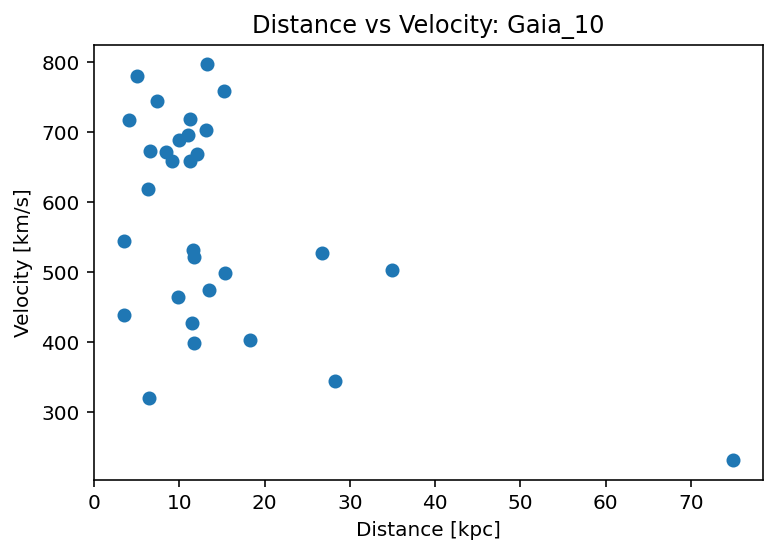

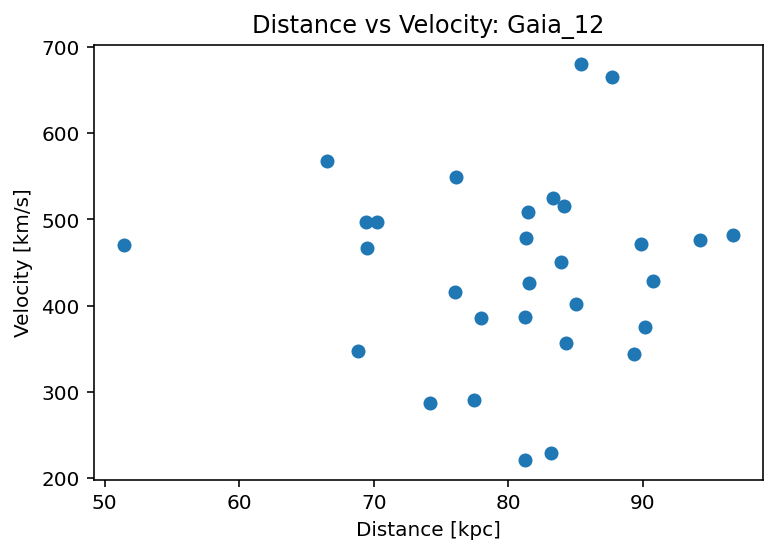

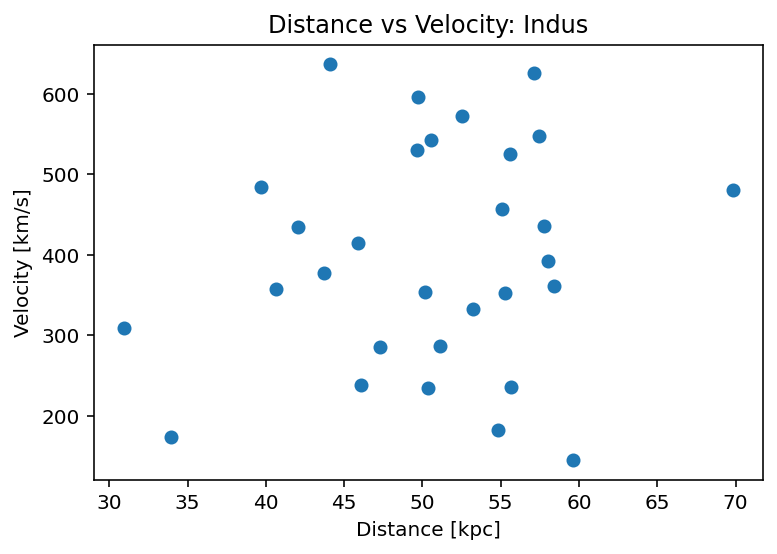

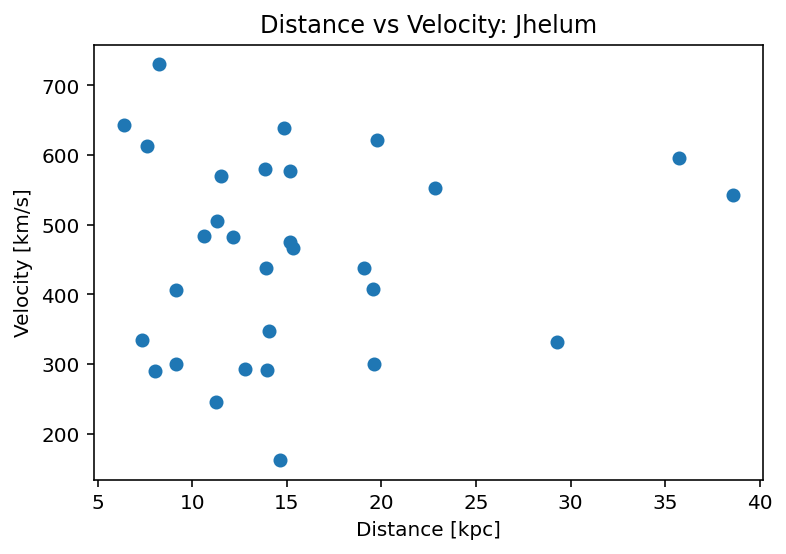

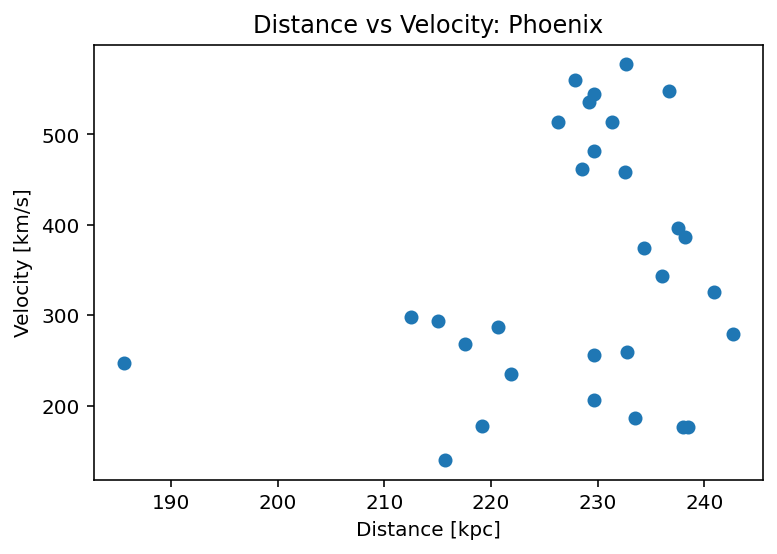

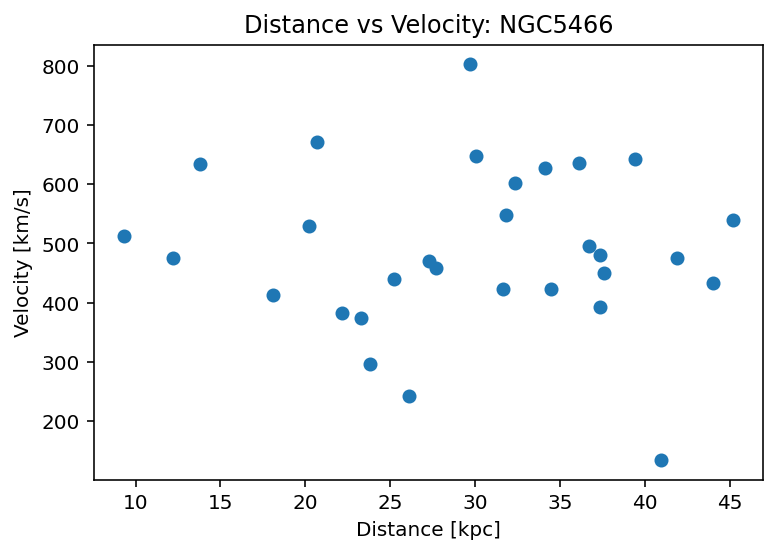

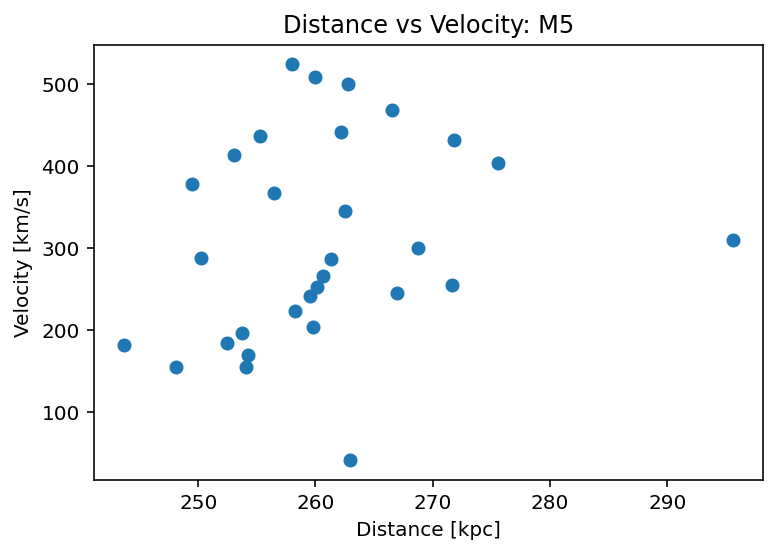

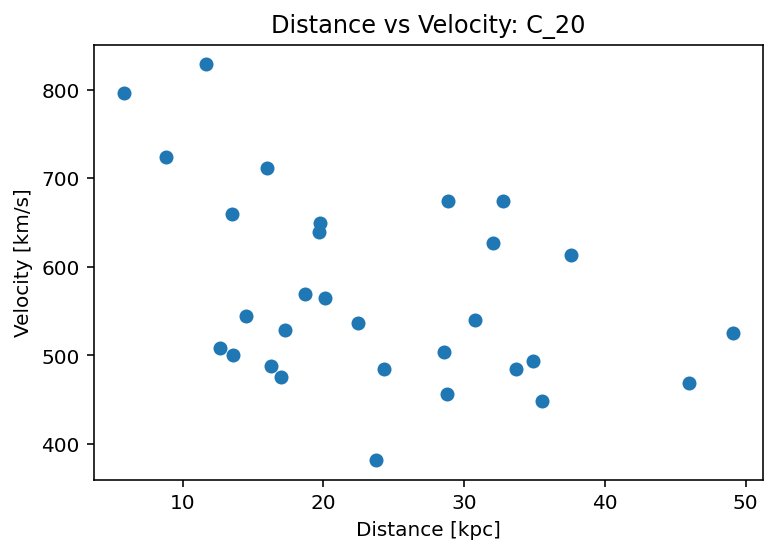

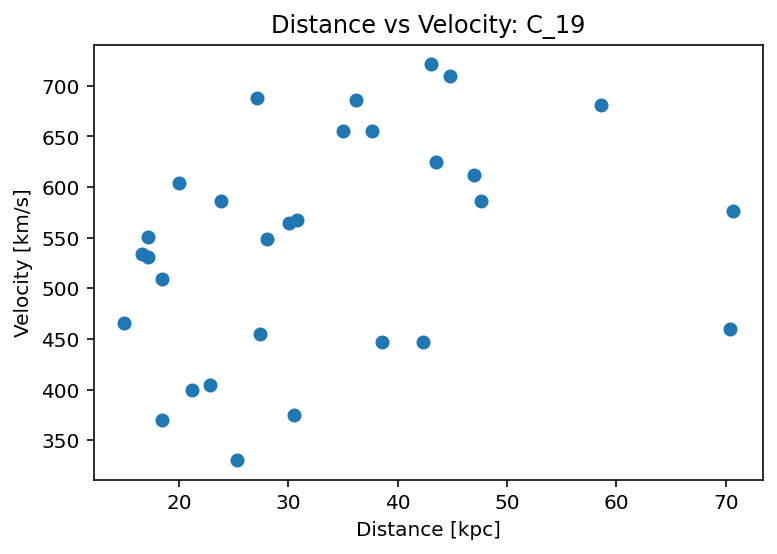

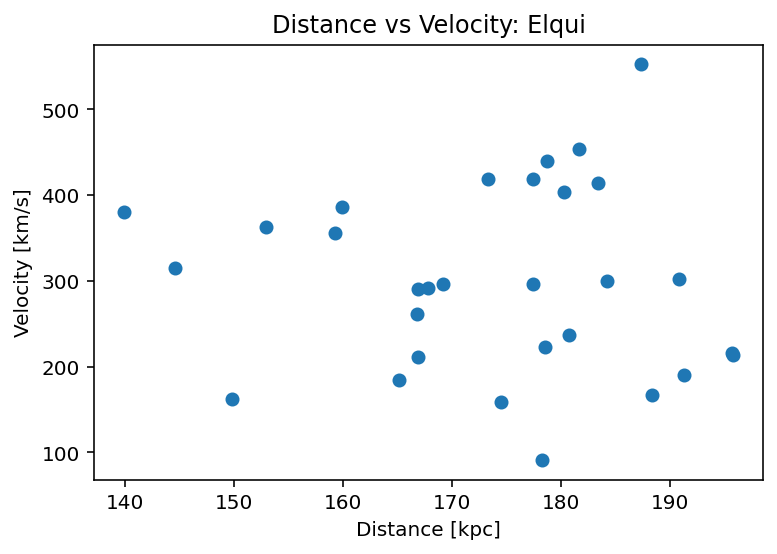

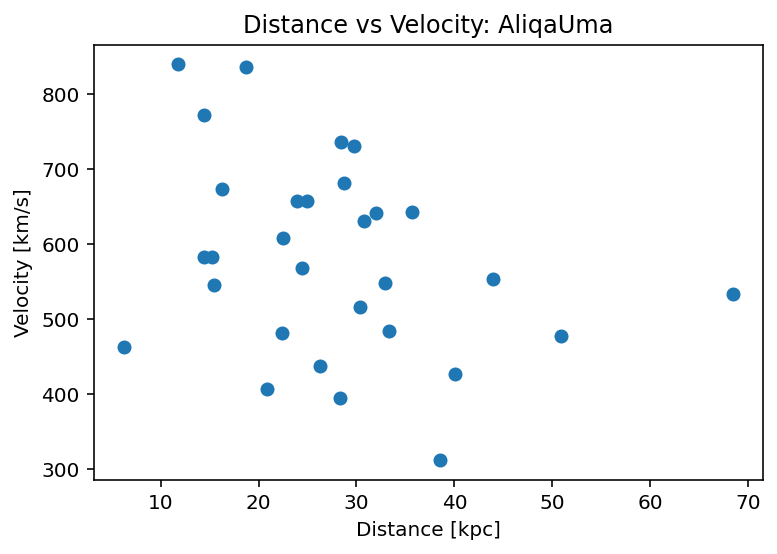

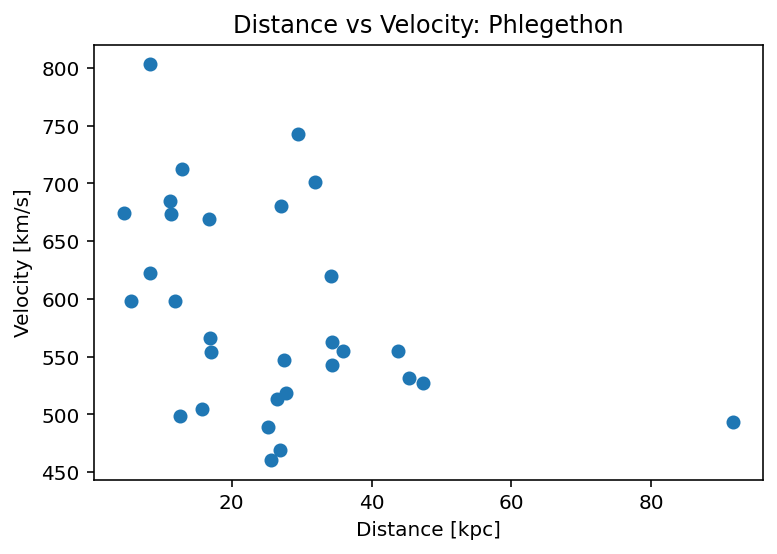

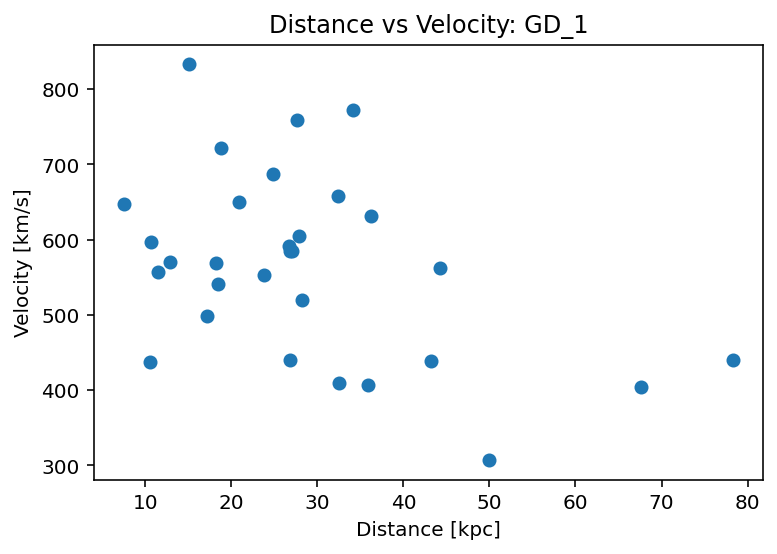

In [52]:
for i in range(len(pb)):
    plt.figure()
    plt.scatter(pb['Subhalo_'+str(i)+' Distance (kpc)'],pb['Subhalo_'+str(i)+' Relative Velocity (km/s)']) 
    plt.xlabel('Distance [kpc]')
    plt.ylabel('Velocity [km/s]')
    plt.title('Distance vs Velocity: '+str(pb.iloc[i][0]))
    #plt.legend(loc='best')
    plt.savefig('Distance_vs_Velocity/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    

In [36]:
#masses is the mass of the subhalo 
#smallest distance between subhalo to stream 
#vmin relative velocity at that point 

vkick_inv = (rmin * vmin) / (2*G*masses[:,np.newaxis])
vkick_inv[vkick_inv==0] = np.nan
vkick = (vkick_inv**-1).to(u.km/u.s)

delta_v = 2*G*mass_subh / (r_min * v_rel) #start with this one 
#take one stream and add up all the velocity kicks (add the squares then take sqaree root)
#and then put this on the streams table 

NameError: name 'rmin' is not defined

In [137]:
#Calculation of Velocity Kick
#This is for GJOLL

G = 6.6743*10**(-11) #gravitational constant
r_min = np.min(pb_new.iloc[0][1:]) #smallest distance between subhalos and stream 
v_rel = pb.iloc[0]['Subhalo_'+str(np.argmin(pb_new.iloc[0][1:]))+' Relative Velocity (km/s)'] #relative vel btwn strean and subhalos 
mass_subh = np.array(ts[ind_massive]['mvir']) #mass of subhalos

delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
vel_kick = np.sqrt(np.sum(delta_v**2))
vel_kick


0.050977893

In [124]:
#Calculation of Velocity Kick
vel_kick = np
for i in range(len(pb)):
    G = 6.6743*10**(-11) #gravitational constant
    r_min = np.min(pb_new.iloc[i][1:]) #smallest distance between subhalos and stream 
    v_rel = pb.iloc[i]['Subhalo_'+str(np.argmin(pb_new.iloc[i][1:]))+' Relative Velocity (km/s)'] #relative vel btwn strean and subhalos 
    mass_subh = np.array(ts[ind_massive]['mvir']) #mass of subhalos

    delta_v_temp = 2*G*mass_subh/(r_min*v_rel) 
    vel_kick = vel_kick.append(delta_v_temp) #Should be 30 x 1072 
vel_kick

    
    

AttributeError: 'NoneType' object has no attribute 'append'

In [22]:
streams['r_apo'] = np.nan
streams['r_peri'] = np.nan

In [23]:
streams_copy = streams.copy()

for i in range(len(streams['Stream'][:])):
    if streams['Stream'][i] in list(r_apo.keys()):
        streams_copy['r_apo'][i] = r_apo[streams['Stream'][i]]
        streams_copy['r_peri'][i] = r_peri[streams['Stream'][i]]
        

<ipython-input-23-27d5bfcf547a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy['r_apo'][i] = r_apo[streams['Stream'][i]]
<ipython-input-23-27d5bfcf547a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy['r_peri'][i] = r_peri[streams['Stream'][i]]


In [24]:
streams_copy

,Stream,ra,dec,distance,pm_ra_cosdec,pm_dec,radial_velocity,r_apo,r_peri
0,Gjoll,82.10,-13.95,3.26,23.58,-23.70,78.73,27.4,8.5
1,Leiptr,89.11,-28.37,7.39,10.59,-9.90,194.22,45.1,12.3
2,Hrid,280.51,33.30,2.75,-5.88,20.08,-238.77,22.0,1.1
3,Pal5,229.65,0.26,20.16,-2.75,-2.68,-57.03,15.8,6.9
4,Gaia_1,190.96,-9.16,5.57,-14.39,-19.72,214.91,67.6,8.2
5,Ylgr,173.82,-22.31,9.72,-0.44,-7.65,317.86,20.7,11.5
6,Fjorm,251.89,65.38,6.42,3.92,3.10,-25.37,29.1,9.1
7,Kshir,205.88,67.25,9.57,-7.67,-3.92,-249.88,16.0,13.4
8,Gunnthra,284.22,-73.49,2.83,-15.83,-24.04,132.26,7.2,4.2
9,Slidr,160.05,10.22,2.99,-24.60,-6.65,87.98,32.3,8.7


In [25]:
streams_copy.to_csv('Streams_data.csv', index='False')


In [ ]:
#Smallest Distance on y axis and apocenter on x axis for all streams

In [40]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDistNoTime(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    for i in range(len(streams)): #goes through every stream
        c = coord.SkyCoord(ra=streams.iloc[i]['ra']*u.deg, dec=streams.iloc[i]['dec']*u.deg, 
                           distance=streams.iloc[i]['distance']*u.kpc, pm_ra_cosdec=streams.iloc[i]['pm_ra_cosdec']*u.mas/u.yr,
                           pm_dec=streams.iloc[i]['pm_dec']*u.mas/u.yr, radial_velocity=streams.iloc[i]['radial_velocity']*u.km/u.s, frame='icrs')

        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


        dt = 1*u.Myr
        Nstep_foward = 2
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

        w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
        Nstep = 7
        orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
        orbit_sky = orbit.to_coord_frame(coord.ICRS())
        
        #Going back for 3 Gyrs (3000 steps of -1Myr)
        Nstep_long = 3000
        orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

        
        
        data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
        data_temp = pd.DataFrame(data=data_new)
        for subh in range(len(trot['x'])): #subh stands for individual subhalo
            dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
            dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
            dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
            rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
            closest_dist2 = np.min(rel_dist)
            
            data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
   
            
        closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1

    #closest_dist.to_csv('Closest_Rel_Dist_to_Subhalos.csv', index='False')







In [41]:
pb_new = ClosestDistNoTime(streams)

<ipython-input-44-f18070418c8b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


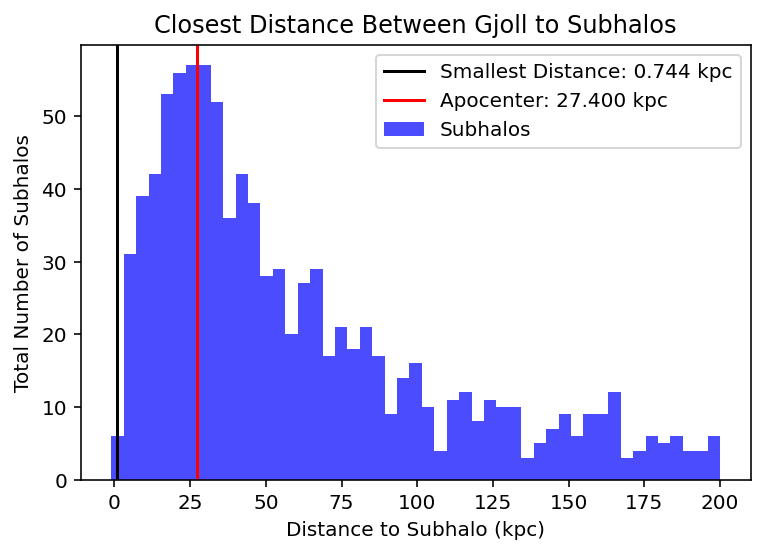

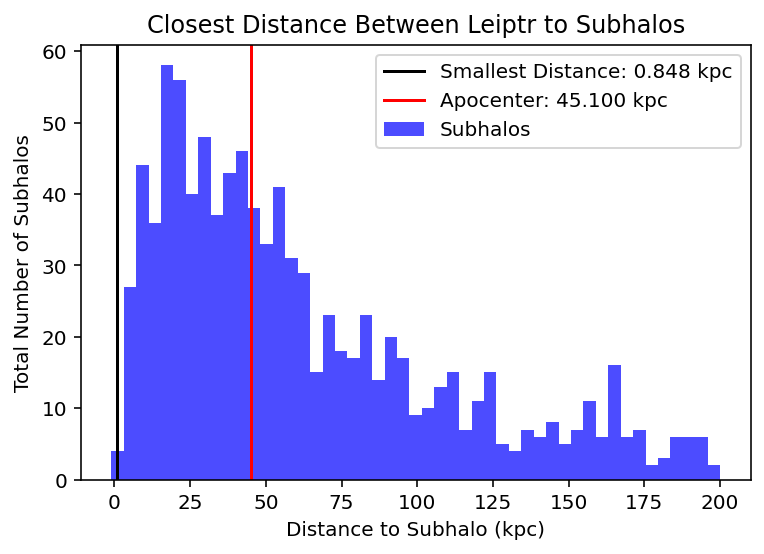

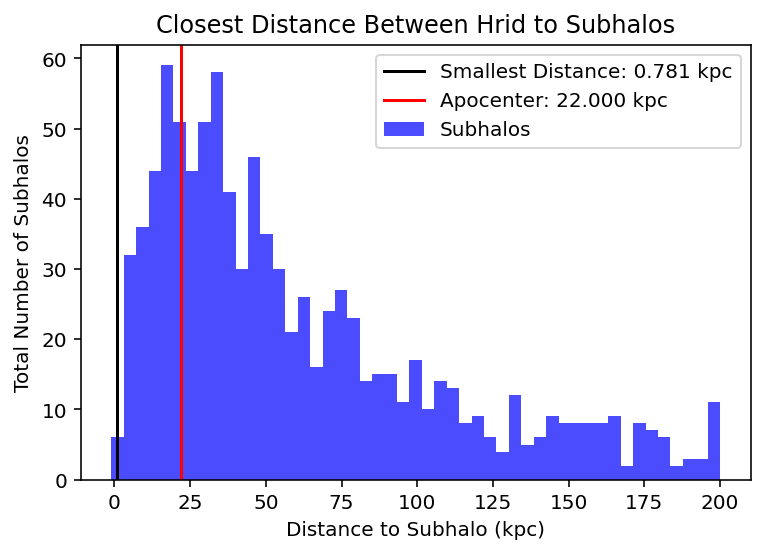

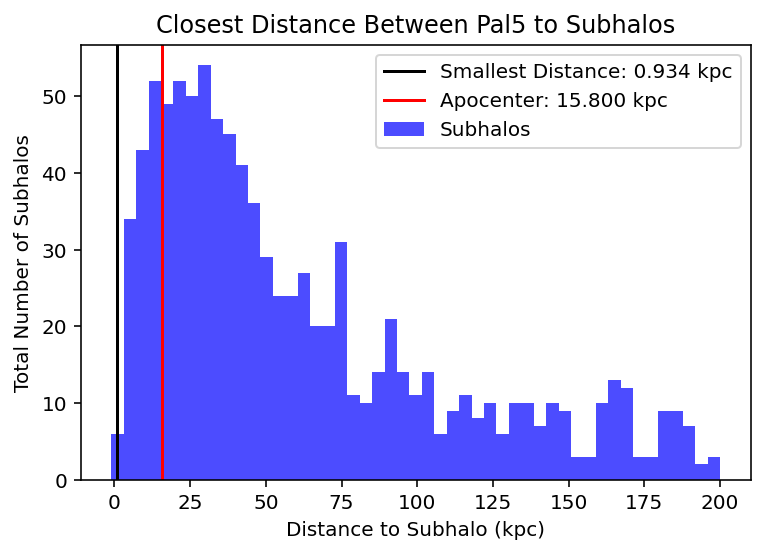

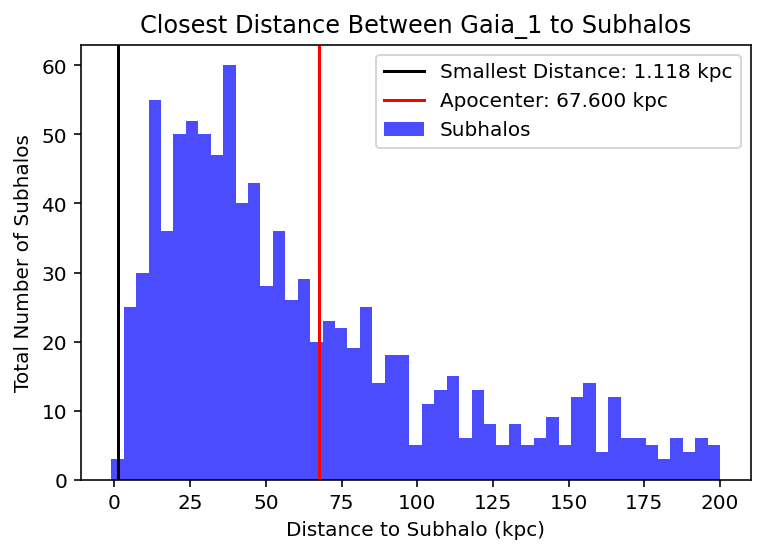

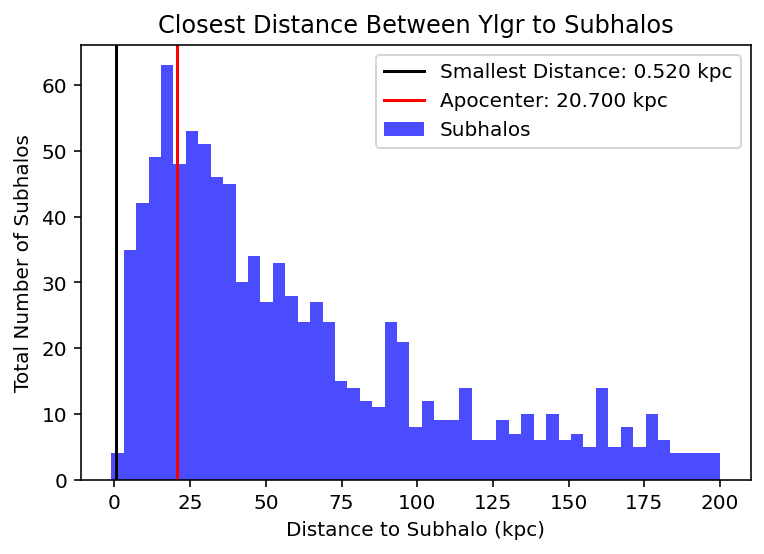

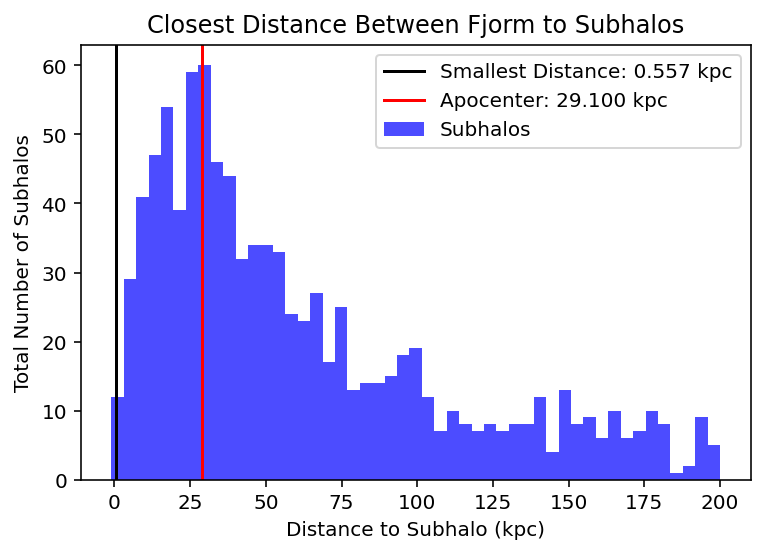

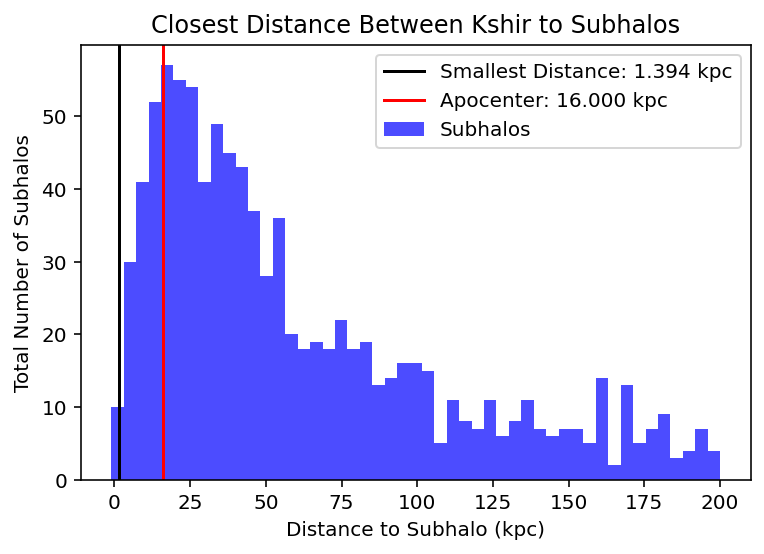

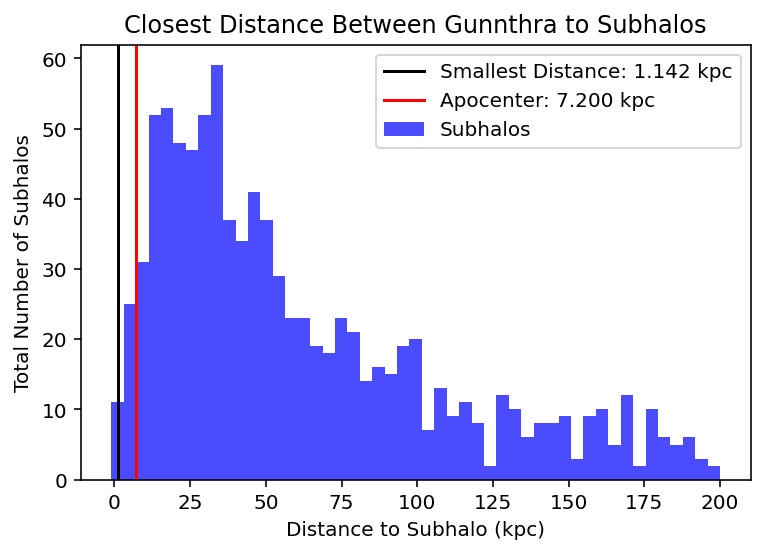

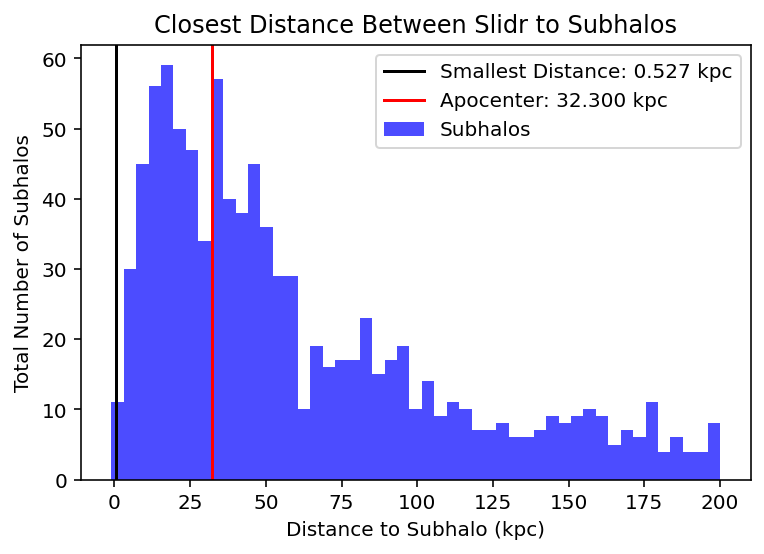

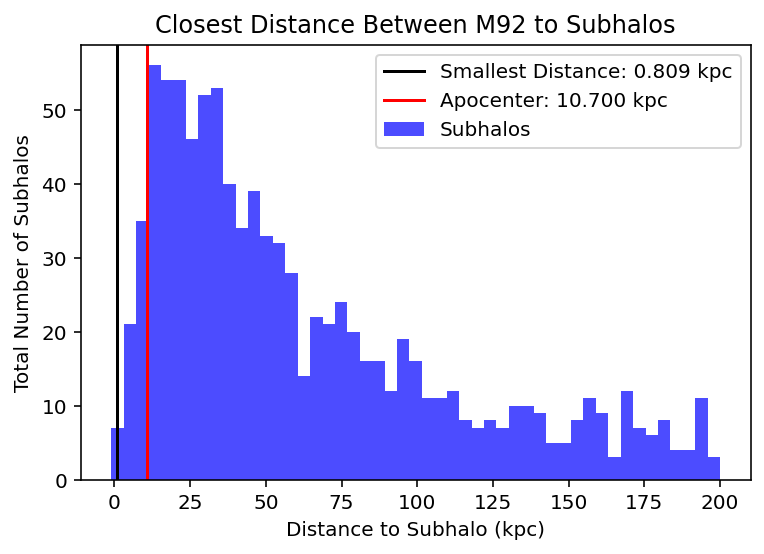

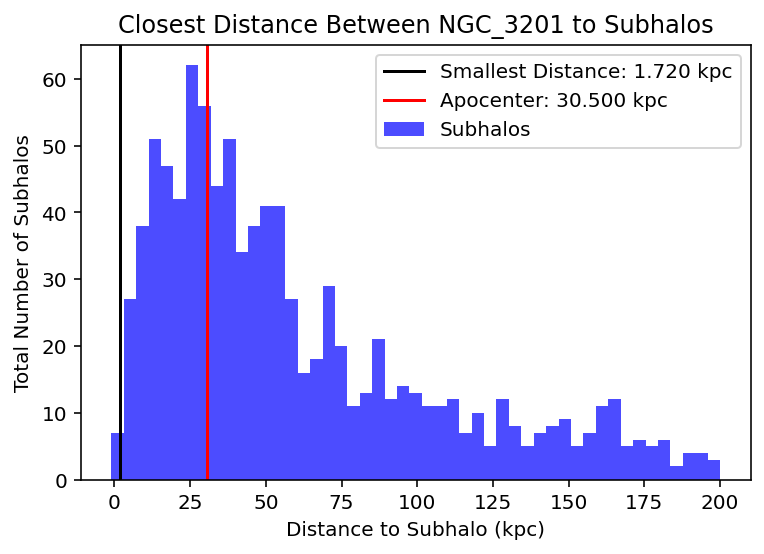

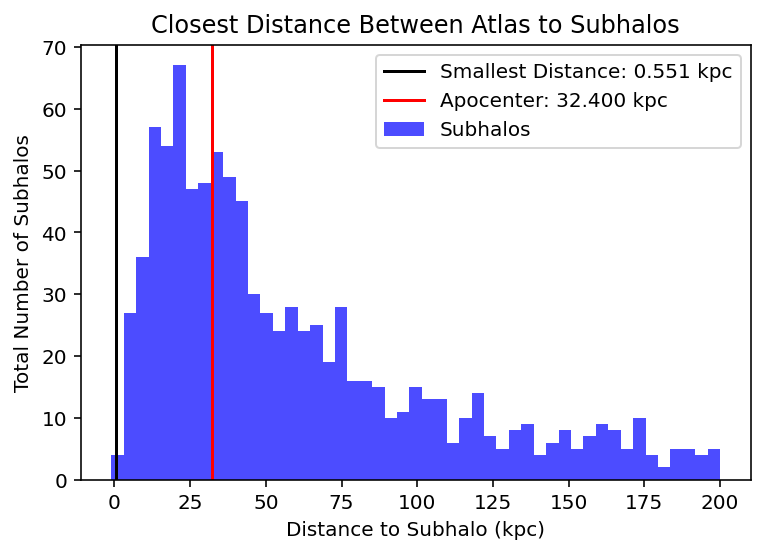

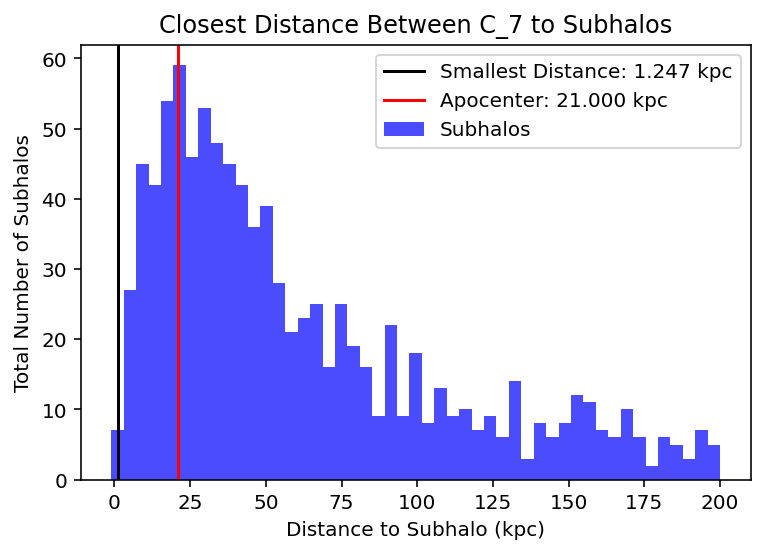

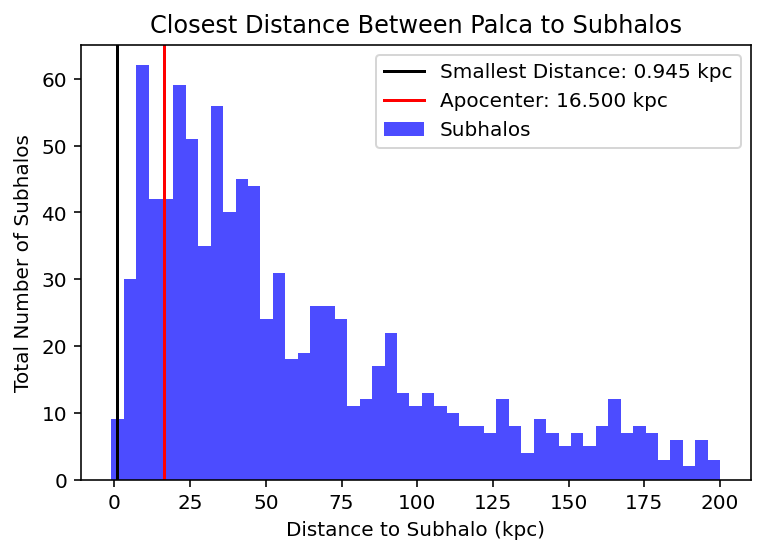

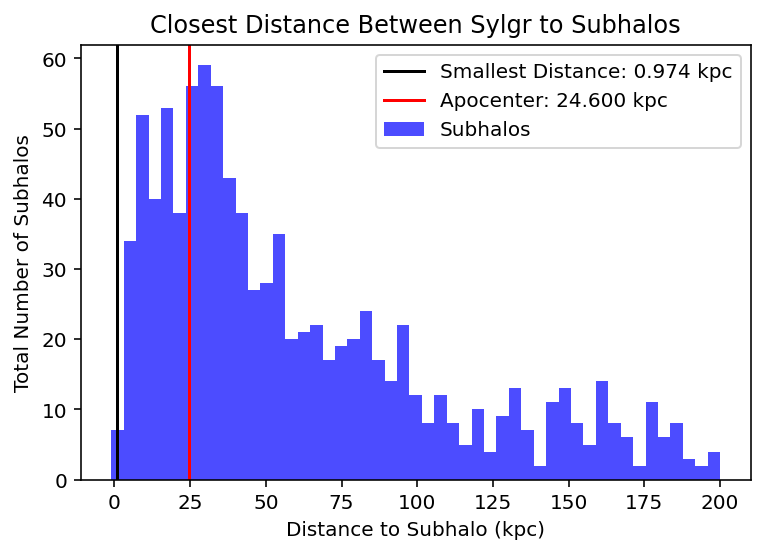

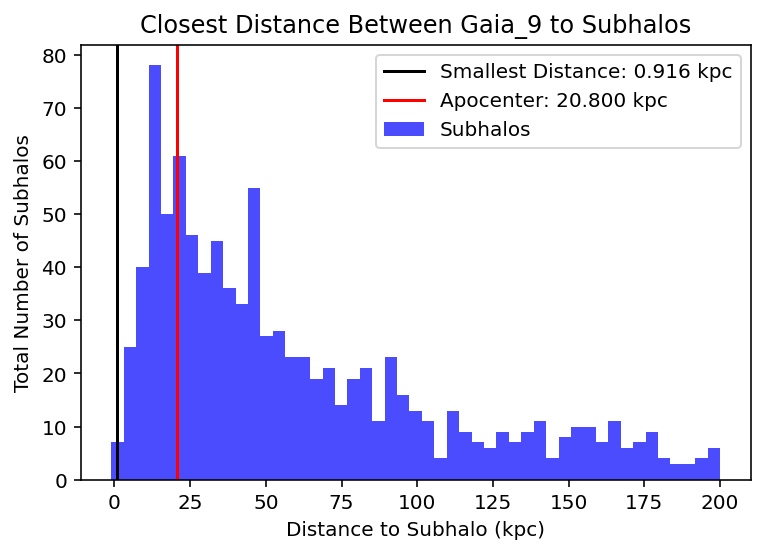

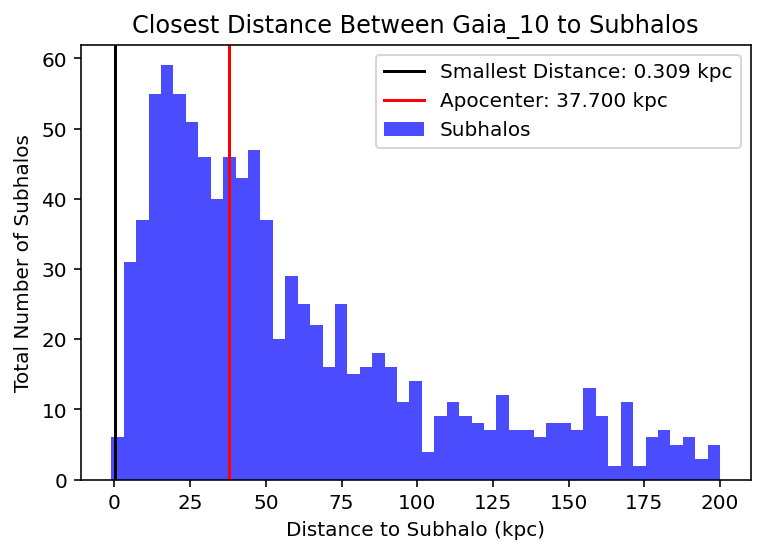

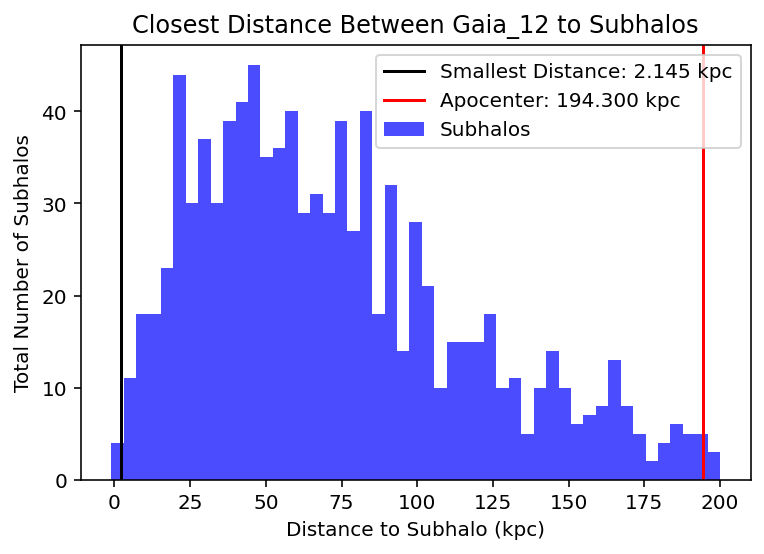

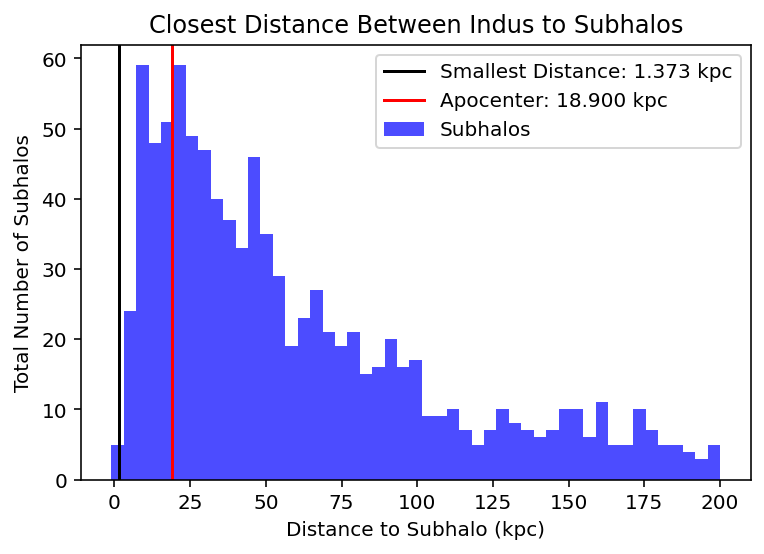

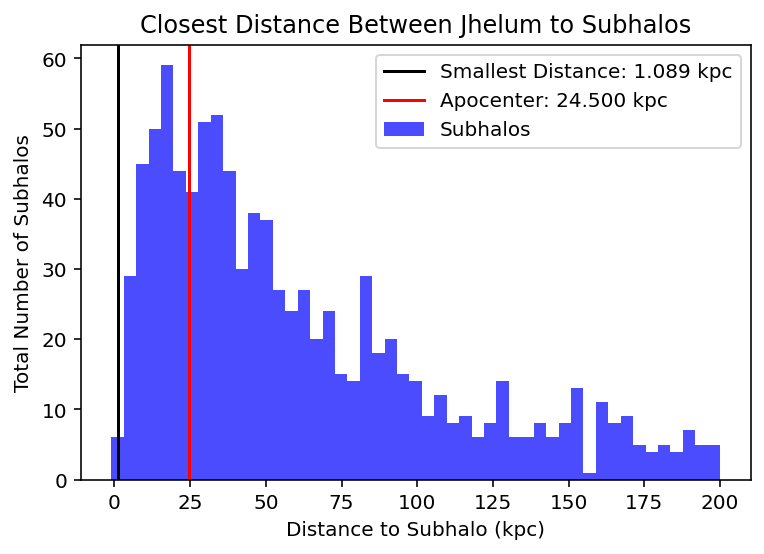

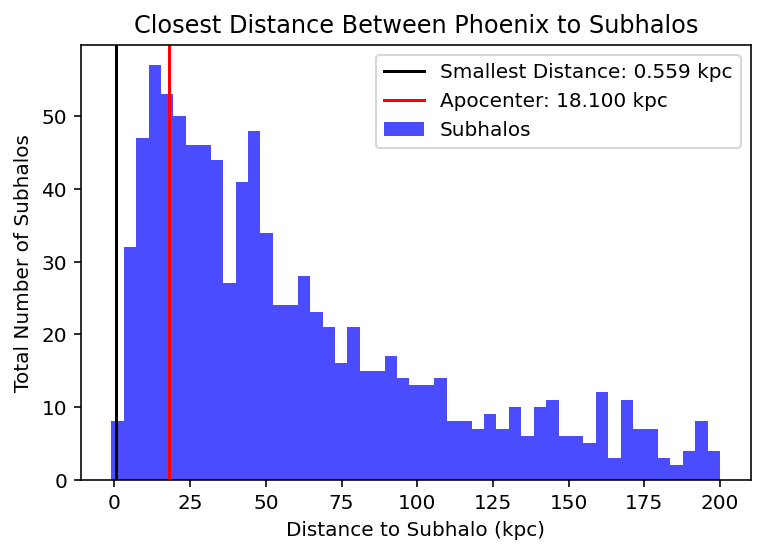

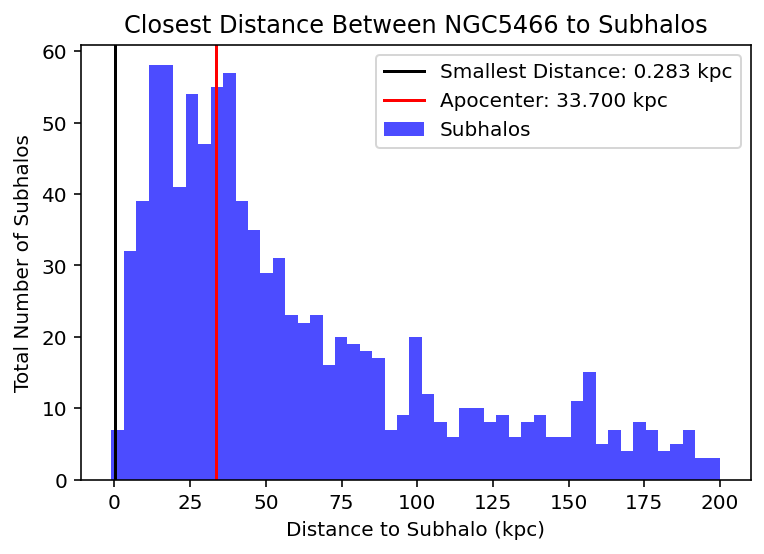

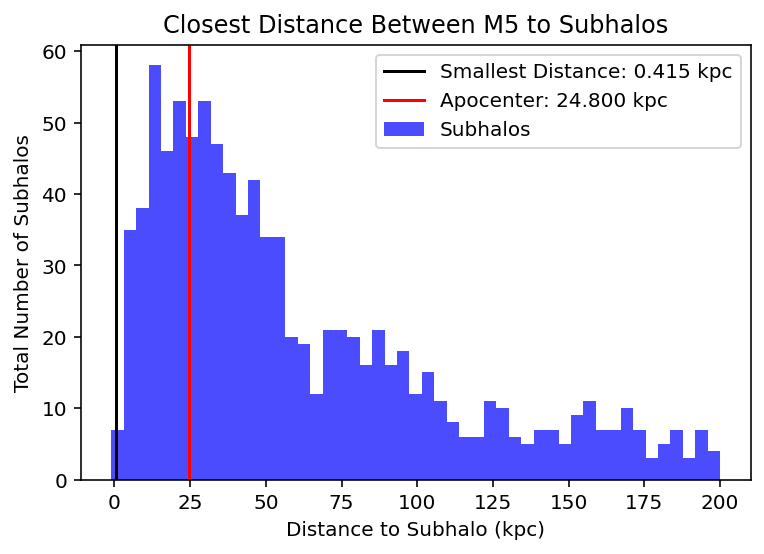

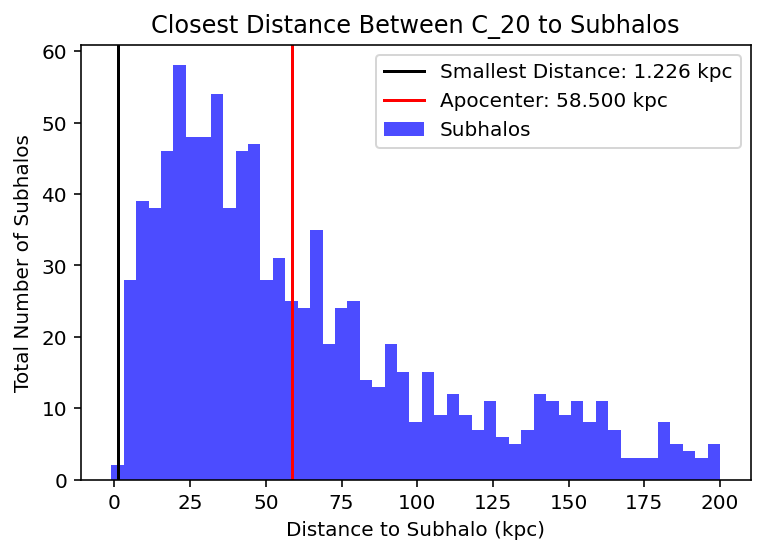

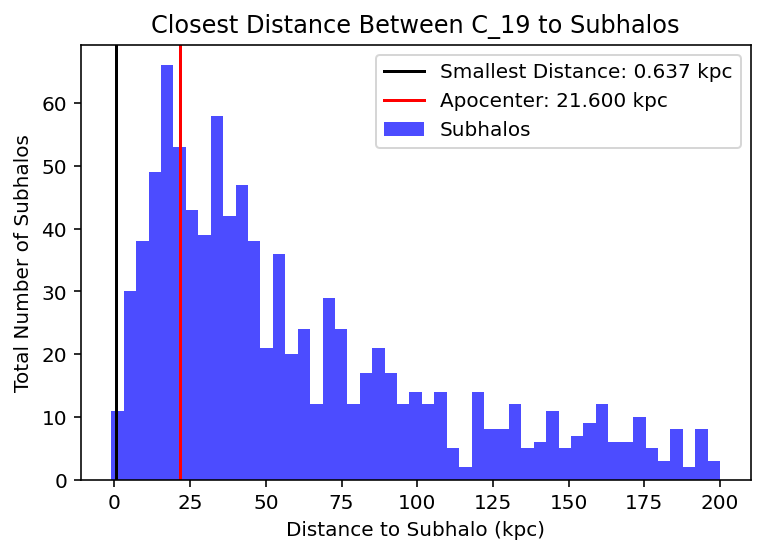

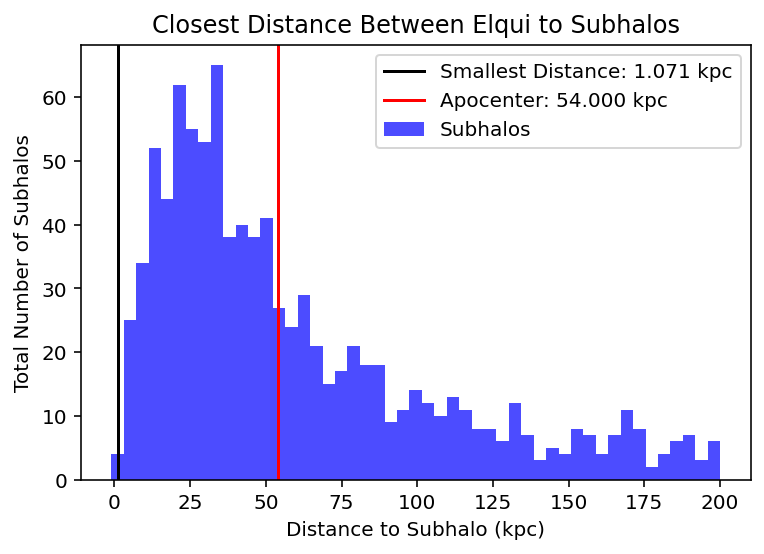

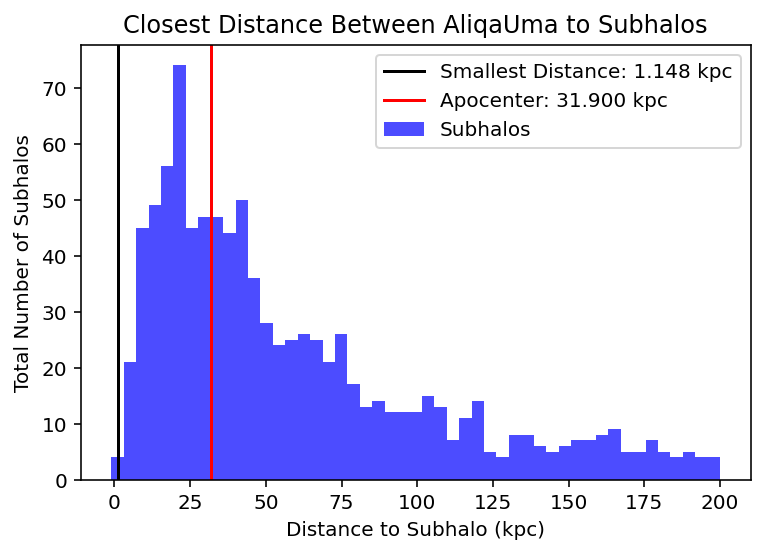

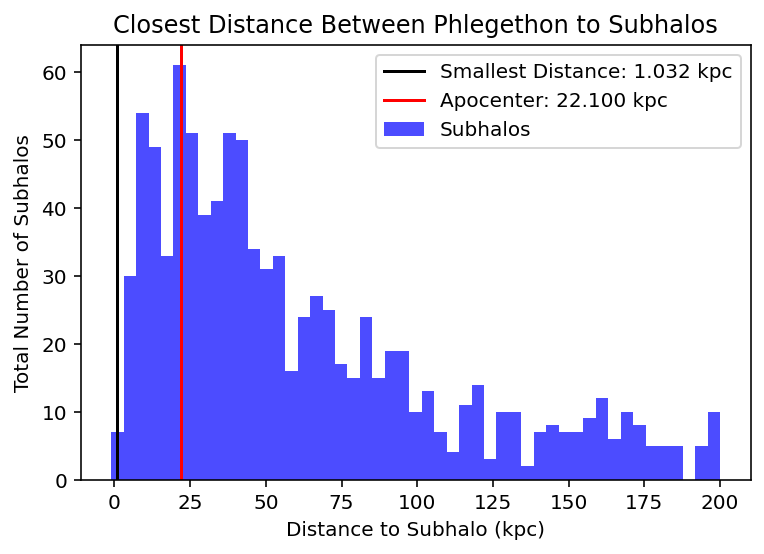

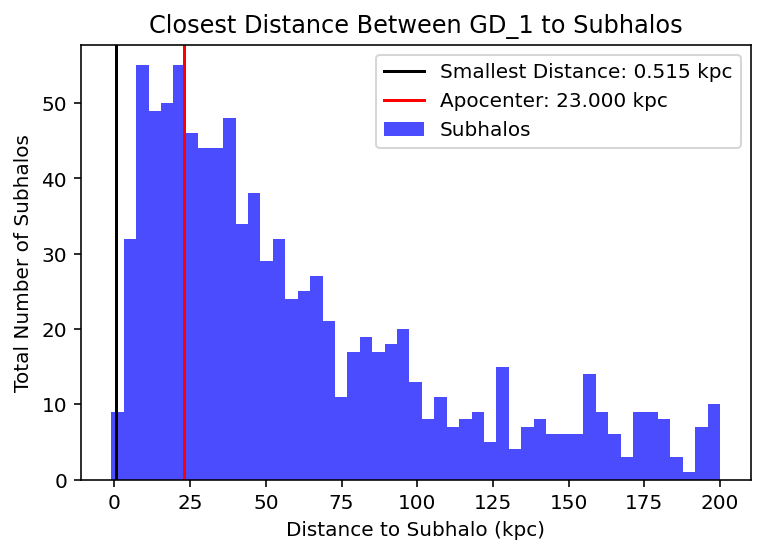

In [44]:
#Creates Histograms for All Streams 
#Include both Apocenter and Pericenter
for i in range(len(pb_new)):
    plt.figure()
    plt.hist(pb_new.iloc[i][1:], bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
    plt.axvline(min(pb_new.iloc[i][1:]), color='black', label = 'Smallest Distance: {:.3f} kpc'.format(min(pb_new.iloc[i][1:])))
    for key in range(len(r_apo.keys())):
        if pb_new.iloc[i][0] == list(r_apo.keys())[key]:
            plt.axvline(r_apo[pb_new.iloc[i][0]], color='red', label = 'Apocenter: {:.3f} kpc'.format(r_apo[pb_new.iloc[i][0]]))
    plt.title('Closest Distance Between {:s} to Subhalos'.format(pb_new.iloc[i][0]))
    plt.xlabel('Distance to Subhalo (kpc)')
    plt.ylabel('Total Number of Subhalos')
    plt.legend(loc='best')
    plt.savefig('Stream_to_Subhalo_Histograms/'+str(pb_new.iloc[i][0])+'.png', transparent=False, dpi=200)

In [ ]:
#TEST For Above Code
i = 0 
plt.figure()
plt.hist(pb.iloc[i][1:], bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
plt.axvline(min(pb.iloc[i][1:]), color='black', label = 'Smallest Distance: {:.3f} kpc'.format(min(pb.iloc[i][1:])))
for key in range(len(r_apo.keys())):
    if pb.iloc[i][0] == list(r_apo.keys())[key]:
        plt.axvline(r_apo[pb.iloc[i][0]], color='black', label = 'Apocenter: {:.3f} kpc'.format(r_apo[pb.iloc[i][0]]))
plt.title('Closest Distance Between {:s} to Subhalos'.format(pb.iloc[i][0]))
plt.xlabel('Distance to Subhalo (kpc)')
plt.ylabel('Total Number of Subhalos')
plt.legend(loc='best')
plt.savefig('Stream_to_Subhalo_Histograms/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)